# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S13

## Panel a

In [2]:
import pandas as pd

stability_weights_3state_2ndorder = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order2/task_1/weights/weights_Binding.txt',
                       sep='\t')
stability_weights_3state_2ndorder.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in stability_weights_3state_2ndorder.iterrows():
    if row['id'] != 'WT':
        stability_weights_3state_2ndorder.at[index,'order']=len(row.id.split('_'))
    else:
        stability_weights_3state_2ndorder.at[index,'order']=0

stability_weights_3state_1storder=pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order1/task_1/weights/weights_Binding.txt',
                   sep='\t')

for index, row in stability_weights_3state_1storder.iterrows():
    if row.id != 'WT':
        stability_weights_3state_1storder.at[index,'order']=len(row.id_ref.split('_'))
    else:
        stability_weights_3state_1storder.at[index,'order']=0

stability_weights_3state_1storder.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol'}, inplace=True)

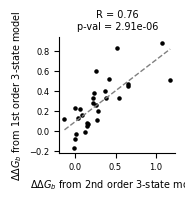

In [3]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

stability_weights_3state_2ndorder = stability_weights_3state_2ndorder.rename(columns={'mean_kcal_mol':'mean_kcal_mol_3state'})
stability_weights_3state_1storder = stability_weights_3state_1storder.rename(columns={'mean_kcal_mol':'mean_kcal_mol_2state'})

singles_folding_ddGs_2statevs3statemodels = stability_weights_3state_2ndorder.loc[stability_weights_3state_2ndorder['order']==1].merge(stability_weights_3state_1storder.loc[stability_weights_3state_1storder['order']==1], left_on='id', right_on='id')

singles_folding_ddGs_2statevs3statemodels=singles_folding_ddGs_2statevs3statemodels.sort_values('mean_kcal_mol_3state')

x = singles_folding_ddGs_2statevs3statemodels[['mean_kcal_mol_3state']].to_numpy()
y = singles_folding_ddGs_2statevs3statemodels[['mean_kcal_mol_2state']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
singles_folding_ddGs_2statevs3statemodels.plot.scatter('mean_kcal_mol_3state','mean_kcal_mol_2state', ax=ax, color='k', s=5)
ax.set_xlabel(r'${ΔΔG_{b}}$ from 2nd order 3-state model', fontsize=7)
ax.set_ylabel(r'${ΔΔG_{b}}$ from 1st order 3-state model', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_1storderterms_1storder3statemodel_vs_1storder2statemodel_FoldingddGs_TrueWT_recalibrated.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel b

In [4]:
coefs = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order2/task_1/weights/weights_Binding.txt',
                       sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    coefs.at[index,'order']=len(row.id.split('_'))
singles_boundary=max(abs(coefs['mean_kcal_mol']))
firstorderterms=coefs.loc[coefs['order']==1].copy()

for index, row in firstorderterms.iterrows():
    firstorderterms.at[index,'mut_from']=row.id[0:-1]
    firstorderterms.at[index,'wt_res']=row.id[0]
    firstorderterms.at[index,'mut_pos']=row.id[1:-1]
    firstorderterms.at[index,'mut_to']=row.id[-1]

real_pos = [2,16,18,24,26,48,53]
mutated_positions = []

for index, row in firstorderterms.iterrows():
    if row.id !='WT' and row.mut_from not in mutated_positions:
        mutated_positions.append(row.mut_from)

secondorderterms=coefs.loc[coefs['order']==2].copy()

wt ='FLFFIIV'
mut_pos_name = [2,16,18,24,26,48,53]


secondorderterms['mutation1']='a'
secondorderterms['mutation2']='a'
for index,row in secondorderterms.iterrows():
    secondorderterms.at[index,'mutation1']=row.id.split('_')[0]
    secondorderterms.at[index,'mutation2']=row.id.split('_')[1]

for index, row in secondorderterms.iterrows():
    secondorderterms.at[index,'pos1']=int(row.mutation1[1:-1])
    secondorderterms.at[index,'pos2']=int(row.mutation2[1:-1])
secondorderterms=secondorderterms.sort_values(['pos1','pos2'])

single_mutations=[]
for index, row in secondorderterms.iterrows():
    if row.mutation1 not in single_mutations:
        single_mutations.append(row.mutation1)
for index, row in secondorderterms.iterrows():
    if row.mutation2 not in single_mutations:
        single_mutations.append(row.mutation2)

couplings_boundary=max(abs(secondorderterms['mean_kcal_mol']))

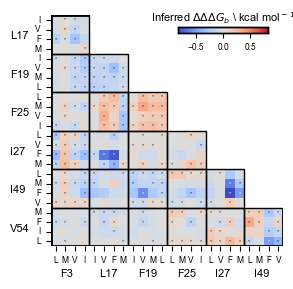

In [5]:
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

plt.rcParams['font.family'] = 'Arial'

pairwise_secondorderterms=pd.DataFrame(columns=single_mutations)

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation1,row.mutation2]=row.mean_kcal_mol

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation2,row.mutation1]=row.mean_kcal_mol

pairwise_secondorderterms=pairwise_secondorderterms.fillna(0)
pairwise_secondorderterms=pairwise_secondorderterms.reindex(single_mutations)

fig, ax=plt.subplots(figsize=(3,3))
for mutation_nr, mutation in enumerate(mutated_positions[1:]):
    plt.text(-4.2, 2.5+4*mutation_nr, mutation, fontsize=8)
for mutation_nr, mutation in enumerate(mutated_positions[:-1]):
    plt.text(1+4*mutation_nr, 27.2, mutation, fontsize=8)

# Create a custom mask
mask = np.zeros_like(pairwise_secondorderterms.iloc[4:,:-4], dtype=bool)
for i in range(len(pairwise_secondorderterms.iloc[4:,:-4].index)):
    for j in range(i+1, len(pairwise_secondorderterms.iloc[4:,:-4].index)):  # Only mask rows and columns in the upper diagonal
        if (i // 4) < (j // 4):  # Mask entire quadrants in the upper diagonal
            mask[i, j] = True


coefs_sparse_model = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order2_sparseregularized/task_4/weights/weights_Binding.txt',
                       sep='\t')
coefs_sparse_model.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs_sparse_model.iterrows():
    coefs_sparse_model.at[index,'order']=len(row.id.split('_'))
coefs_sparse_model=coefs_sparse_model.set_index('id')

sparse_regularized_selected = pd.DataFrame(index=pairwise_secondorderterms.index, columns=pairwise_secondorderterms.columns)
for coupling in list(coefs_sparse_model.loc[coefs_sparse_model['order']==2].index):
    mutations=coupling.split('_')
    sparse_regularized_selected.at[mutations[0],mutations[1]]='*'
    sparse_regularized_selected.at[mutations[1],mutations[0]]='*'
    
sparse_regularized_selected=sparse_regularized_selected.fillna('')

cbar_ax=fig.add_axes([0.55,0.82,0.3,0.02])
hmap=sns.heatmap(pairwise_secondorderterms.iloc[4:,:-4], cmap='coolwarm', center=0, xticklabels=True,yticklabels=True, mask=mask,vmin=-1*couplings_boundary, vmax=couplings_boundary,
              cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-1,1.5,0.5))}, ax=ax, cbar_ax=cbar_ax, annot=sparse_regularized_selected.iloc[4:,:-4].mask(mask).to_numpy().tolist(), fmt= '', annot_kws={'size':4})

cbar_ax.set_xlabel(r'Inferred ${ΔΔΔG_{b}}$ \ kcal mol$^-$$^1$', rotation=0, fontsize=8)
cbar_ax.xaxis.set_label_position('top')
for spine in cbar_ax.spines.values():
    spine.set(visible=True,lw=1,edgecolor='black')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
    
labels_x = [item.get_text() for item in ax.get_xticklabels()]
for label_nr, label in enumerate(labels_x):
    labels_x[label_nr]=label[-1]
ax.set_xticklabels(labels_x, rotation=0,fontsize=6)
labels_y = [item.get_text() for item in ax.get_yticklabels()]
for label_nr, label in enumerate(labels_y):
    labels_y[label_nr]=label[-1]
ax.set_yticklabels(labels_y, rotation=0,fontsize=6)

for i in range(0, len(pairwise_secondorderterms.iloc[4:,:-4].index), 4):
    for j in range(0, len(pairwise_secondorderterms.iloc[4:,:-4].index), 4):
        if not np.any(mask[i:i+4, j:j+4]):
            rect = Rectangle((j, i), 4, 4, linewidth=1, edgecolor='black', facecolor='none')
            ax.add_patch(rect)

ax.axhline(y=len(pairwise_secondorderterms.iloc[4:,:-4].index), color='k',linewidth=2)
ax.axhline(y=0,xmin=0,xmax=0.16, color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
ax.axvline(x=len(pairwise_secondorderterms.iloc[4:,:-4].index),ymin=0,ymax=0.16, color='k',linewidth=2)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_SH3_2or_pairwisecoup_binding.svg', dpi=300, transparent=True, bbox_inches = "tight")
            

## Panel c

In [6]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig7'+'/FYN_coreDTS_bPCA_order2/task_1/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

predicted_abundance = predicted_phenotypes.loc[predicted_phenotypes['Abundance']==1]
predicted_binding = predicted_phenotypes.loc[predicted_phenotypes['Binding']==1]

In [7]:
# Normalize data

from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

RT=303*0.001987

predicted_abundance_scaled = predicted_abundance.copy()
predicted_binding_scaled = predicted_binding.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

# Normalize abundance fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_abundance_scaled['fitness']=        normalize(list(predicted_abundance_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness1_uncorr']=normalize(list(predicted_abundance_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness2_uncorr']=normalize(list(predicted_abundance_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize abundance fitness predictions

for index, row in predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True].iterrows():
    predicted_abundance_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_abundance_scaled.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_abundance_scaled['predicted_fitness']=           normalize(list(predicted_abundance_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred folding ddGs

predicted_abundance_scaled['mean_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].mean(axis=1)
predicted_abundance_scaled['std_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].std(axis=1)

predicted_abundance_scaled['mean_ddG']= predicted_abundance_scaled['mean_additive_trait']*RT
predicted_abundance_scaled['std_ddG']=  predicted_abundance_scaled['std_additive_trait']*RT

# Normalize binding fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_binding_scaled['fitness']=        normalize(list(predicted_binding_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness1_uncorr']=normalize(list(predicted_binding_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness2_uncorr']=normalize(list(predicted_binding_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness3_uncorr']=normalize(list(predicted_binding_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize binding fitness predictions

for index, row in predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].iterrows():
    predicted_binding_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_binding_scaled.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_binding_scaled['predicted_fitness']=           normalize(list(predicted_binding_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred binding ddGs

predicted_binding_scaled['mean_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].mean(axis=1)
predicted_binding_scaled['std_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].std(axis=1)

predicted_binding_scaled['mean_ddG']= predicted_binding_scaled['mean_additive_trait']*RT
predicted_binding_scaled['std_ddG']=  predicted_binding_scaled['std_additive_trait']*RT

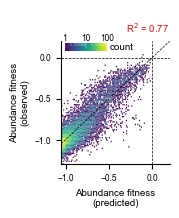

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

y = predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True][['fitness']].to_numpy()
x = predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True][['predicted_fitness']].to_numpy()
model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)

fig, ax = plt.subplots(figsize=(1.4,1.6))
hbin=ax.hexbin(x=predicted_abundance_scaled['predicted_fitness'].loc[predicted_abundance_scaled['WT']!=True],y=predicted_abundance_scaled['fitness'].loc[predicted_abundance_scaled['WT']!=True],bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=100)
ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)


plt.axvline(0, ls='--', color='black', lw=0.5)
plt.axhline(0, ls='--', color='black', lw=0.5)
plt.title('\nR$^2$ = '+str(round(r2_score(y,y_pred),2)),fontsize=7, color='r', loc='right')
plt.xlabel('Abundance fitness\n(predicted)', fontsize=7)
plt.xticks(fontsize=6)
plt.ylabel('Abundance fitness\n(observed)', fontsize=7)
plt.yticks(fontsize=6)
ax.set_xticks(np.arange(-1.5,0.5,0.5))
ax.set_yticks(np.arange(-1.5,0.5,0.5))
ax.set_ylim(-1.3,0.2)
ax.set_xlim(-1.05,0.2)
ax.spines[['top','right']].set_visible(False)
ax.set_rasterization_zorder(0)
fmt = '%1.f'
cax=fig.add_axes([0.15,0.82,0.3,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
cb.set_ticks([1,10,100])
cb.set_ticklabels([1,10,100], fontsize=6)
ax1 = cb.ax
ax1.text(140,0.1,'count',rotation=0, fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_2ndorder_abundance_performance_bindingPCA.svg', dpi=300, transparent=True, bbox_inches='tight')


## Panel d

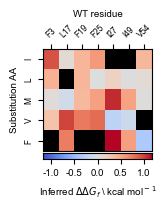

In [9]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

coefs = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order2/task_1/weights/weights_Folding.txt',
                       sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    if row['id'] != 'WT':
        coefs.at[index,'order']=len(row.id.split('_'))
    else:
        coefs.at[index,'order']=0
coefs_2ndor=coefs.copy()


firstorderterms=coefs.loc[coefs['order']==1].copy()

for index, row in firstorderterms.iterrows():
    firstorderterms.at[index,'mut_from']=row.id[0:-1]
    firstorderterms.at[index,'wt_res']=row.id[0]
    firstorderterms.at[index,'mut_pos']=row.id[1:-1]
    firstorderterms.at[index,'mut_to']=row.id[-1]

real_pos = [2,16,18,24,26,48,53]
mutated_positions = []

for index, row in firstorderterms.iterrows():
    if row.id !='WT' and row.mut_from not in mutated_positions:
        mutated_positions.append(row.mut_from)

coefs_hm=pd.DataFrame(columns=mutated_positions)

for index, row in firstorderterms.iterrows():
    if row.id !='WT':
        coefs_hm.at[row.mut_to,row.mut_from]=row.mean_kcal_mol

fig, ax = plt.subplots(figsize=(1.4,1.6))

#singles_boundary=max(abs(coefs['mean_kcal_mol']))
ax=sns.heatmap(coefs_hm.fillna(0), cmap='coolwarm', vmin=-1*singles_boundary, vmax=singles_boundary,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom'}, xticklabels=True, yticklabels=True)
ax.figure.axes[-1].set_xticks(ticks=np.arange(-1,1.5,0.5),labels=np.arange(-1,1.5,0.5),fontsize=7)
ax.figure.axes[-1].set_xlabel(r'Inferred ${ΔΔG_{f}}$ \ kcal mol$^-$$^1$', rotation=0, labelpad=5, fontsize=7)
ax.figure.axes[-1].spines[['top','bottom','left','right']].set_visible(True)
ax.spines[['top','bottom','left','right']].set_visible(True)
plt.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(fontsize=6)
plt.xticks(fontsize=6, rotation=45)
plt.xlabel('WT residue',  fontsize=7)
ax.xaxis.set_label_position('top') 
plt.ylabel('Substitution AA', fontsize=7)

for i in mutated_positions:
    for j in mutated_positions:
        if i[0]==j[0]:
            col=coefs_hm.columns.get_loc(i)
            row=coefs_hm.index.get_loc(j[0])
            ax.add_patch(Rectangle((col, row), 1, 1, fill=True,edgecolor='black', lw=0.0001, facecolor='black'))
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_1storderterms_folding_2ndorder3statemodel_ddGs.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel e

In [10]:
import pandas as pd

stability_weights_3state_2ndorder = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order2/task_1/weights/weights_Folding.txt',
                       sep='\t')
stability_weights_3state_2ndorder.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in stability_weights_3state_2ndorder.iterrows():
    if row['id'] != 'WT':
        stability_weights_3state_2ndorder.at[index,'order']=len(row.id.split('_'))
    else:
        stability_weights_3state_2ndorder.at[index,'order']=0

stability_weights_2state_2ndorder=pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2/task_1/weights/weights_Folding.txt',
                   sep='\t')

for index, row in stability_weights_2state_2ndorder.iterrows():
    if row.id != 'WT':
        stability_weights_2state_2ndorder.at[index,'order']=len(row.id_ref.split('_'))
    else:
        stability_weights_2state_2ndorder.at[index,'order']=0

stability_weights_2state_2ndorder.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol'}, inplace=True)

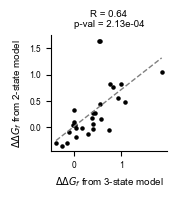

In [11]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

stability_weights_3state_2ndorder = stability_weights_3state_2ndorder.rename(columns={'mean_kcal_mol':'mean_kcal_mol_3state'})
stability_weights_2state_2ndorder = stability_weights_2state_2ndorder.rename(columns={'mean_kcal_mol':'mean_kcal_mol_2state'})

singles_folding_ddGs_2statevs3statemodels = stability_weights_3state_2ndorder.loc[stability_weights_3state_2ndorder['order']==1].merge(stability_weights_2state_2ndorder.loc[stability_weights_2state_2ndorder['order']==1], left_on='id', right_on='id')

singles_folding_ddGs_2statevs3statemodels=singles_folding_ddGs_2statevs3statemodels.sort_values('mean_kcal_mol_3state')

x = singles_folding_ddGs_2statevs3statemodels[['mean_kcal_mol_3state']].to_numpy()
y = singles_folding_ddGs_2statevs3statemodels[['mean_kcal_mol_2state']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
singles_folding_ddGs_2statevs3statemodels.plot.scatter('mean_kcal_mol_3state','mean_kcal_mol_2state', ax=ax, color='k', s=5)
ax.set_xlabel(r'${ΔΔG_{f}}$ from 3-state model', fontsize=7)
ax.set_ylabel(r'${ΔΔG_{f}}$ from 2-state model', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_1storderterms_1storder3statemodel_vs_1storder2statemodel_FoldingddGs_TrueWT_recalibrated.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel f

In [12]:
coefs = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order2/task_1/weights/weights_Folding.txt',
                       sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    if row['id'] != 'WT':
        coefs.at[index,'order']=len(row.id.split('_'))
    else:
        coefs.at[index,'order']=0

secondorderterms=coefs.loc[coefs['order']==2].copy()

wt ='FLFFIIV'
mut_pos_name = [2,16,18,24,26,48,53]


secondorderterms['mutation1']='a'
secondorderterms['mutation2']='a'
for index,row in secondorderterms.iterrows():
    secondorderterms.at[index,'mutation1']=row.id.split('_')[0]
    secondorderterms.at[index,'mutation2']=row.id.split('_')[1]

for index, row in secondorderterms.iterrows():
    secondorderterms.at[index,'pos1']=int(row.mutation1[1:-1])
    secondorderterms.at[index,'pos2']=int(row.mutation2[1:-1])
secondorderterms=secondorderterms.sort_values(['pos1','pos2'])

single_mutations=[]
for index, row in secondorderterms.iterrows():
    if row.mutation1 not in single_mutations:
        single_mutations.append(row.mutation1)
for index, row in secondorderterms.iterrows():
    if row.mutation2 not in single_mutations:
        single_mutations.append(row.mutation2)    

couplings_boundary=max(abs(secondorderterms['mean_kcal_mol']))

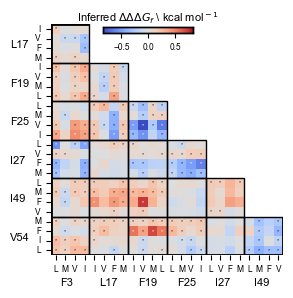

In [13]:
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib.pyplot as plt
import math
#from matplotlib.colors import TwoSlopeNorm

plt.rcParams['font.family'] = 'Arial'

pairwise_secondorderterms=pd.DataFrame(columns=single_mutations)

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation1,row.mutation2]=row.mean_kcal_mol

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation2,row.mutation1]=row.mean_kcal_mol

pairwise_secondorderterms=pairwise_secondorderterms.fillna(0)
pairwise_secondorderterms=pairwise_secondorderterms.reindex(single_mutations)

#plt.figure(figsize=(5,4))
fig, ax=plt.subplots(figsize=(3,3))
for mutation_nr, mutation in enumerate(mutated_positions[1:]):
    plt.text(-4.2, 2.5+4*mutation_nr, mutation, fontsize=8)
for mutation_nr, mutation in enumerate(mutated_positions[:-1]):
    plt.text(1+4*mutation_nr, 27.2, mutation, fontsize=8)

# Create a custom mask
mask = np.zeros_like(pairwise_secondorderterms.iloc[4:,:-4], dtype=bool)
for i in range(len(pairwise_secondorderterms.iloc[4:,:-4].index)):
    for j in range(i+1, len(pairwise_secondorderterms.iloc[4:,:-4].index)):  # Only mask rows and columns in the upper diagonal
        if (i // 4) < (j // 4):  # Mask entire quadrants in the upper diagonal
            mask[i, j] = True


coefs_sparse_model = pd.read_csv(path+'Fig7/'+'FYN_coreDTS_bPCA_order2_sparseregularized/task_4/weights/weights_Folding.txt',
                       sep='\t')
coefs_sparse_model.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs_sparse_model.iterrows():
    coefs_sparse_model.at[index,'order']=len(row.id.split('_'))
coefs_sparse_model=coefs_sparse_model.set_index('id')

sparse_regularized_selected = pd.DataFrame(index=pairwise_secondorderterms.index, columns=pairwise_secondorderterms.columns)
for coupling in list(coefs_sparse_model.loc[coefs_sparse_model['order']==2].index):
    mutations=coupling.split('_')
    sparse_regularized_selected.at[mutations[0],mutations[1]]='*'
    sparse_regularized_selected.at[mutations[1],mutations[0]]='*'
    
sparse_regularized_selected=sparse_regularized_selected.fillna('')
#sparse_regularized_selected=sparse_regularized_selected.replace('*','')

            
cbar_ax=fig.add_axes([0.3,0.85,0.3,0.02])
hmap=sns.heatmap(pairwise_secondorderterms.iloc[4:,:-4], cmap='coolwarm', center=0, xticklabels=True,yticklabels=True, mask=mask,vmin=-1*couplings_boundary, vmax=couplings_boundary,
              cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-1,1.5,0.5))}, ax=ax, cbar_ax=cbar_ax, annot=sparse_regularized_selected.iloc[4:,:-4].mask(mask).to_numpy().tolist(), fmt= '', annot_kws={'size':4})


cbar_ax.set_xlabel(r'Inferred ${ΔΔΔG_{f}}$ \ kcal mol$^-$$^1$', rotation=0, fontsize=8)
cbar_ax.xaxis.set_label_position('top')
for spine in cbar_ax.spines.values():
    spine.set(visible=True,lw=1,edgecolor='black')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
    
labels_x = [item.get_text() for item in ax.get_xticklabels()]
for label_nr, label in enumerate(labels_x):
    labels_x[label_nr]=label[-1]
ax.set_xticklabels(labels_x, rotation=0,fontsize=6)
labels_y = [item.get_text() for item in ax.get_yticklabels()]
for label_nr, label in enumerate(labels_y):
    labels_y[label_nr]=label[-1]
ax.set_yticklabels(labels_y, rotation=0,fontsize=6)

for i in range(0, len(pairwise_secondorderterms.iloc[4:,:-4].index), 4):
    for j in range(0, len(pairwise_secondorderterms.iloc[4:,:-4].index), 4):
        if not np.any(mask[i:i+4, j:j+4]):
            rect = Rectangle((j, i), 4, 4, linewidth=1, edgecolor='black', facecolor='none')
            ax.add_patch(rect)

ax.axhline(y=len(pairwise_secondorderterms.iloc[4:,:-4].index), color='k',linewidth=2)
ax.axhline(y=0,xmin=0,xmax=0.16, color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
ax.axvline(x=len(pairwise_secondorderterms.iloc[4:,:-4].index),ymin=0,ymax=0.16, color='k',linewidth=2)
    
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_SH3_2or_pairwisecoup_folding.svg', dpi=300, transparent=True, bbox_inches = "tight")
            

## Panel g

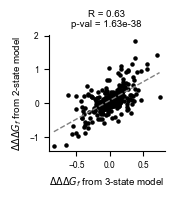

In [14]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

stability_weights_3state_2ndorder = stability_weights_3state_2ndorder.rename(columns={'mean_kcal_mol':'mean_kcal_mol_3state'})
stability_weights_2state_2ndorder = stability_weights_2state_2ndorder.rename(columns={'mean_kcal_mol':'mean_kcal_mol_2state'})

singles_folding_ddGs_2statevs3statemodels = stability_weights_3state_2ndorder.loc[stability_weights_3state_2ndorder['order']==2].merge(stability_weights_2state_2ndorder.loc[stability_weights_2state_2ndorder['order']==2], left_on='id', right_on='id')

singles_folding_ddGs_2statevs3statemodels=singles_folding_ddGs_2statevs3statemodels.sort_values('mean_kcal_mol_3state')

x = singles_folding_ddGs_2statevs3statemodels[['mean_kcal_mol_3state']].to_numpy()
y = singles_folding_ddGs_2statevs3statemodels[['mean_kcal_mol_2state']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
singles_folding_ddGs_2statevs3statemodels.plot.scatter('mean_kcal_mol_3state','mean_kcal_mol_2state', ax=ax, color='k', s=5)
ax.set_xlabel(r'${ΔΔΔG_{f}}$ from 3-state model', fontsize=7)
ax.set_ylabel(r'${ΔΔΔG_{f}}$ from 2-state model', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_Mochi_2ndorderterms_2ndorder3statemodel_vs_2ndorder2statemodel_FoldingddGs_TrueWT_recalibrated.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel h

In [15]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'FigS13'+'/FYN_coreDTS_bPCA_norm_order2/task_1/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

predicted_abundance = predicted_phenotypes.loc[predicted_phenotypes['Abundance']==1].copy()
predicted_binding = predicted_phenotypes.loc[predicted_phenotypes['Binding']==1].copy()

linear_weights_abundance = pd.read_csv(path+'FigS13'+'/FYN_coreDTS_bPCA_norm_order2/task_1/weights/'+'linears_weights_Abundance.txt',
                                      sep='\t')
linear_weights_binding = pd.read_csv(path+'FigS13'+'/FYN_coreDTS_bPCA_norm_order2/task_1/weights/'+'linears_weights_Binding.txt',
                                    sep='\t')
weights_binding = pd.read_csv(path+'FigS13'+'/FYN_coreDTS_bPCA_norm_order2/task_1/weights/'+'weights_Binding.txt',
                             sep='\t')

In [16]:
import math
import statistics
RT=0.001987*(273+30)

for i in range(1,11,1):
    fold = i
    
    folding_fitness = predicted_abundance[['fitness']]
    folding_linear_kernel = linear_weights_abundance.loc[linear_weights_abundance['fold']==fold].iloc[0]['kernel']
    folding_linear_bias = linear_weights_abundance.loc[linear_weights_abundance['fold']==fold].iloc[0]['bias']
    binding_linear_kernel = linear_weights_binding.loc[linear_weights_binding['fold']==fold].iloc[0]['kernel']
    binding_linear_bias = linear_weights_binding.loc[linear_weights_binding['fold']==fold].iloc[0]['bias']
    b_dg_wt = weights_binding.loc[weights_binding['id']=='WT'].iloc[0]['fold_'+str(fold)]*RT
    
    Cb = math.exp(b_dg_wt/RT)
    predicted_abundance['binding_fitness_from_abundance_fitness_fold'+str(i)]=binding_linear_kernel/(Cb*folding_linear_kernel/(folding_fitness-folding_linear_bias)+1)+binding_linear_bias
for index, row in predicted_abundance.iterrows():
    binding_fitness_from_abundance_fitness = []
    for i in range(1,11,1):
        binding_fitness_from_abundance_fitness.append(row['binding_fitness_from_abundance_fitness_fold'+str(i)])
    predicted_abundance.at[index,'binding_fitness_from_abundance_fitness']=statistics.mean(binding_fitness_from_abundance_fitness)

In [17]:
predicted_abundance = predicted_abundance.rename(columns={'predicted_fitness': 'predicted_stability_fitness'})
predicted_binding = predicted_binding.rename(columns={'predicted_fitness': 'predicted_binding_fitness'})
predicted_abundance = predicted_abundance.rename(columns={'fitness': 'stability_fitness'})
predicted_binding = predicted_binding.rename(columns={'fitness': 'binding_fitness'})
predicted_abundance = predicted_abundance.rename(columns={'mean_ddG': 'folding_ddG'})
predicted_binding = predicted_binding.rename(columns={'mean_ddG': 'binding_ddG'})
predicted_stability_vs_binding = predicted_binding.merge(predicted_abundance, left_on='aa_seq', right_on='aa_seq')

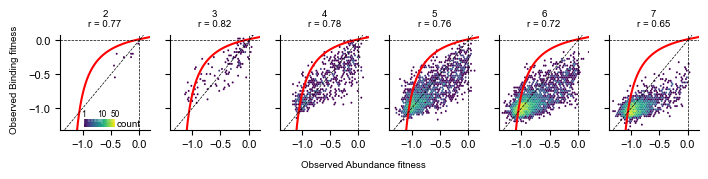

In [18]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Arial'

xlim=(min(predicted_stability_vs_binding['stability_fitness']),max(predicted_stability_vs_binding['stability_fitness']))
ylim=(min(predicted_stability_vs_binding['binding_fitness']),max(predicted_stability_vs_binding['binding_fitness']))

predicted_abundance=predicted_abundance.sort_values('stability_fitness',ascending=True)
x=predicted_abundance['stability_fitness'].iloc[35:]
y=predicted_abundance['binding_fitness_from_abundance_fitness'].iloc[35:]
y_spl=UnivariateSpline(x,y,s=0.0001)
l=len(x.index)-1
x_range = np.linspace(x[0],x[l-1],100000)

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(7,1.7))
coliterator=0
rowiterator=0
for hamm_dist in range(2,8,1):
    
    y = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['binding_fitness']].to_numpy()
    x = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['stability_fitness']].to_numpy()
    
    model = LinearRegression()
    model.fit(x,y)
    
    y_pred = model.predict(x)
    
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=50, rasterized=True,linewidths=0, extent=[min(predicted_stability_vs_binding['stability_fitness']),max(predicted_stability_vs_binding['stability_fitness']),min(predicted_stability_vs_binding['binding_fitness']),max(predicted_stability_vs_binding['binding_fitness'])])
    ax[coliterator].plot(x_range,y_spl(x_range),'-', color='red')

    ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(predicted_stability_vs_binding['binding_fitness']),max(predicted_stability_vs_binding['binding_fitness']))
    ax[coliterator].set_xlim(min(predicted_stability_vs_binding['stability_fitness']),max(predicted_stability_vs_binding['stability_fitness']))
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_xticks([0,-0.5,-1])
    #ax[coliterator].set_xticklabels([0,-0.5,-1])
    ax[coliterator].tick_params(axis='x', labelsize=8)
    ax[coliterator].tick_params(axis='y', labelsize=8)
    ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].set_rasterization_zorder(0)
    if coliterator != 0:
        ax[coliterator].yaxis.set_ticklabels([])
    coliterator+=1
    

fmt = '%1.f'
cax=fig.add_axes([0.1,0.22,0.045,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
cb.set_ticks([1,10,50])
cb.set_ticklabels([1,10,50], fontsize=6, rotation=0)
ax1 = cb.ax
ax1.text(60,0.1,'count',rotation=0, fontsize=7)

fig.text(0.5, -0.015, 'Observed Abundance fitness', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Observed Binding fitness', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_binding_vs_stability_observed_fitness_with_bindingfitnesspredictedfromabundancefitness_2ndorder3statemodel.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel i

In [19]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig7'+'/FYN_coreDTS_bPCA_order2/task_1/predictions/predicted_phenotypes_all.txt',
                                  sep='\t', lineterminator='\n', low_memory=False)

predicted_abundance = predicted_phenotypes.loc[predicted_phenotypes['Abundance']==1]
predicted_binding = predicted_phenotypes.loc[predicted_phenotypes['Binding']==1]

In [20]:
# Normalize data

from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

RT=303*0.001987

predicted_abundance_scaled = predicted_abundance.copy()
predicted_binding_scaled = predicted_binding.copy()

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

# Normalize abundance fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_abundance_scaled['fitness']=        normalize(list(predicted_abundance_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness1_uncorr']=normalize(list(predicted_abundance_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_abundance_scaled['fitness2_uncorr']=normalize(list(predicted_abundance_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize abundance fitness predictions

for index, row in predicted_abundance_scaled.loc[predicted_abundance_scaled['WT']!=True].iterrows():
    predicted_abundance_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_abundance_scaled.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_abundance_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_abundance_scaled['predicted_fitness']=           normalize(list(predicted_abundance_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred folding ddGs

predicted_abundance_scaled['mean_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].mean(axis=1)
predicted_abundance_scaled['std_additive_trait']=predicted_abundance_scaled[['fold_'+str(i)+'_additive_trait0' for i in range(1,11,1)]].std(axis=1)

predicted_abundance_scaled['mean_ddG']= predicted_abundance_scaled['mean_additive_trait']*RT
predicted_abundance_scaled['std_ddG']=  predicted_abundance_scaled['std_additive_trait']*RT

# Normalize binding fitness measurements

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding, x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])


predicted_binding_scaled['fitness']=        normalize(list(predicted_binding_scaled['fitness']),{'actual': {'lower': mode, 'upper':         0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness1_uncorr']=normalize(list(predicted_binding_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness2_uncorr']=normalize(list(predicted_binding_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})
predicted_binding_scaled['fitness3_uncorr']=normalize(list(predicted_binding_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Normalize binding fitness predictions

for index, row in predicted_binding_scaled.loc[predicted_binding_scaled['WT']!=True].iterrows():
    predicted_binding_scaled.at[index,'predicted_fitness']=row['fold_'+str(int(row['Fold']))]
    predicted_binding_scaled.at[index,'predicted_ddG']=row['fold_'+str(int(row['Fold']))+'_additive_trait0']*RT

fig, ax = plt.subplots()

my_kde = kdeplot(data=predicted_binding_scaled, x='predicted_fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])

predicted_binding_scaled['predicted_fitness']=           normalize(list(predicted_binding_scaled['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

# Obtain mean inferred binding ddGs

predicted_binding_scaled['mean_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].mean(axis=1)
predicted_binding_scaled['std_additive_trait']=predicted_binding_scaled[['fold_'+str(i)+'_additive_trait1' for i in range(1,11,1)]].std(axis=1)

predicted_binding_scaled['mean_ddG']= predicted_binding_scaled['mean_additive_trait']*RT
predicted_binding_scaled['std_ddG']=  predicted_binding_scaled['std_additive_trait']*RT

In [21]:
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'predicted_fitness': 'predicted_stability_fitness'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'predicted_fitness': 'predicted_binding_fitness'})
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'fitness': 'stability_fitness'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'fitness': 'binding_fitness'})
predicted_abundance_scaled = predicted_abundance_scaled.rename(columns={'mean_ddG': 'folding_ddG'})
predicted_binding_scaled = predicted_binding_scaled.rename(columns={'mean_ddG': 'binding_ddG'})
predicted_stability_vs_binding = predicted_binding_scaled.merge(predicted_abundance_scaled, left_on='aa_seq', right_on='aa_seq')

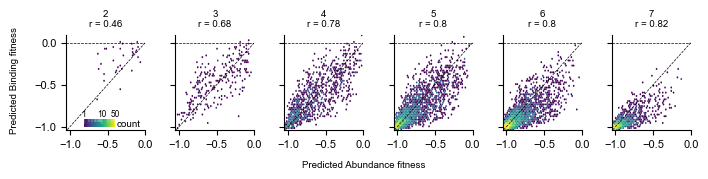

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math

plt.rcParams['font.family'] = 'Arial'

xlim=(min(predicted_stability_vs_binding['predicted_stability_fitness']),max(predicted_stability_vs_binding['predicted_stability_fitness']))
ylim=(min(predicted_stability_vs_binding['predicted_binding_fitness']),max(predicted_stability_vs_binding['predicted_binding_fitness']))

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(7,1.7))
coliterator=0
rowiterator=0
for hamm_dist in range(2,8,1):
    #predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist].plot.scatter(y='stability_fitness', x='binding_fitness')
    
    y = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['predicted_binding_fitness']].to_numpy()
    x = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['predicted_stability_fitness']].to_numpy()
    
    model = LinearRegression()
    model.fit(x,y)
    
    y_pred = model.predict(x)
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=50, rasterized=True,linewidths=0, extent=[min(predicted_stability_vs_binding['predicted_stability_fitness']),max(predicted_stability_vs_binding['predicted_stability_fitness']),min(predicted_stability_vs_binding['predicted_binding_fitness']),max(predicted_stability_vs_binding['predicted_binding_fitness'])])
    ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(predicted_stability_vs_binding['predicted_binding_fitness']),max(predicted_stability_vs_binding['predicted_binding_fitness']))
    ax[coliterator].set_xlim(min(predicted_stability_vs_binding['predicted_stability_fitness']),max(predicted_stability_vs_binding['predicted_stability_fitness']))
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_xticks([0,-0.5,-1])
    #ax[coliterator].set_xticklabels([0,-0.5,-1])
    ax[coliterator].tick_params(axis='x', labelsize=8)
    ax[coliterator].tick_params(axis='y', labelsize=8)
    ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].set_rasterization_zorder(0)
    if coliterator != 0:
        ax[coliterator].yaxis.set_ticklabels([])
    coliterator+=1
    
#fmt = '%1.f'
#cax=fig.add_axes([0.99,0.25,0.005,0.3])
#cb=fig.colorbar(hbin, shrink=0.7,format=fmt,cax=cax)
#cb.ax.set_title('Counts',fontsize=7)
##cb.set_label('counts', rotation=270, fontsize=7, labelpad=8)
#cb.set_ticks([1,5,10,50])
#cb.set_ticklabels([1,5,10,50], fontsize=6)

fmt = '%1.f'
cax=fig.add_axes([0.1,0.22,0.045,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
#cb.ax.set_title('Count', fontsize=7)
#cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
#cb.ax.xaxis.set_label_position('right')
cb.set_ticks([1,10,50])
cb.set_ticklabels([1,10,50], fontsize=6, rotation=0)
ax1 = cb.ax
ax1.text(60,0.1,'count',rotation=0, fontsize=7)

fig.text(0.5, -0.015, 'Predicted Abundance fitness', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Predicted Binding fitness', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_binding_vs_stability_predicted_fitness_2ndordermodel.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel j

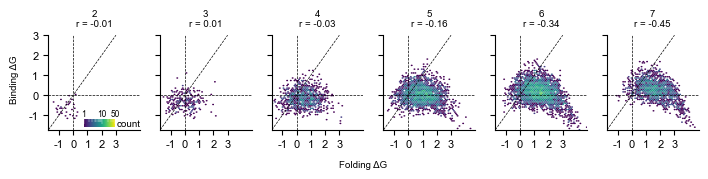

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import math

plt.rcParams['font.family'] = 'Arial'

xlim=(min(predicted_stability_vs_binding['folding_ddG']),max(predicted_stability_vs_binding['folding_ddG']))
ylim=(min(predicted_stability_vs_binding['binding_ddG']),max(predicted_stability_vs_binding['binding_ddG']))

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(7,1.7))
coliterator=0
rowiterator=0
for hamm_dist in range(2,8,1):
    y = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['binding_ddG']].to_numpy()
    x = predicted_stability_vs_binding.loc[predicted_stability_vs_binding['Nham_aa_x']==hamm_dist][['folding_ddG']].to_numpy()
    
    model = LinearRegression()
    model.fit(x,y)
    
    y_pred = model.predict(x)
    
    ax[coliterator].set(xlim=xlim,ylim=ylim)
    hbin=ax[coliterator].hexbin(x,y,gridsize=50,bins='log', vmax=50, rasterized=True,linewidths=0, extent=[min(predicted_stability_vs_binding['folding_ddG']),max(predicted_stability_vs_binding['folding_ddG']),min(predicted_stability_vs_binding['binding_ddG']),max(predicted_stability_vs_binding['binding_ddG'])])
    ax[coliterator].set_title(str(hamm_dist)+'\nr = '+str(round(pearsonr(x.ravel(),y.ravel())[0],2)), fontsize=7)
    ax[coliterator].axline((0, 0), slope=1,ls='dashed',color='k',lw=0.5)
    ax[coliterator].set_ylim(min(predicted_stability_vs_binding['binding_ddG']),max(predicted_stability_vs_binding['binding_ddG']))
    ax[coliterator].set_xlim(min(predicted_stability_vs_binding['folding_ddG']),max(predicted_stability_vs_binding['folding_ddG']))
    ax[coliterator].spines[['right','top']].set_visible(False)
    ax[coliterator].set_xticks(ticks=np.arange(-1,4,1), labels=np.arange(-1,4,1))
    ax[coliterator].set_yticks(ticks=np.arange(-1,4,1), labels=np.arange(-1,4,1))
    #ax[coliterator].set_xticklabels([0,-0.5,-1])
    ax[coliterator].tick_params(axis='x', labelsize=8)
    ax[coliterator].tick_params(axis='y', labelsize=8)
    ax[coliterator].axhline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].axvline(0, ls='--', color='k',lw=0.5)
    ax[coliterator].set_rasterization_zorder(0)
    if coliterator != 0:
        ax[coliterator].yaxis.set_ticklabels([])
    coliterator+=1
    
#fmt = '%1.f'
#cax=fig.add_axes([0.99,0.25,0.005,0.3])
#cb=fig.colorbar(hbin, shrink=0.7,format=fmt,cax=cax)
#cb.ax.set_title('Counts',fontsize=7)
##cb.set_label('counts', rotation=270, fontsize=7, labelpad=8)
#cb.set_ticks([1,5,10,50])
#cb.set_ticklabels([1,5,10,50], fontsize=6)

fmt = '%1.f'
cax=fig.add_axes([0.1,0.22,0.045,0.05])
cb=fig.colorbar(hbin, ax=ax, shrink=0.7,format=fmt,location='top',cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(axis='both', which='both',direction='in', color='white',width=0.25)
cb.ax.xaxis.set_tick_params(pad=0)
#cb.ax.set_title('Count', fontsize=7)
#cb.set_label('count', rotation=0, fontsize=7, labelpad=2)
#cb.ax.xaxis.set_label_position('right')
cb.set_ticks([1,10,50])
cb.set_ticklabels([1,10,50], fontsize=6, rotation=0)
ax1 = cb.ax
ax1.text(60,0.1,'count',rotation=0, fontsize=7)

fig.text(0.5, -0.015, 'Folding ΔG', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Binding ΔG', va='center', rotation='vertical', fontsize=7)
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_binding_vs_stability_ddG_2ndorder3statemodel_byNham_correl.svg', dpi=300, transparent=True, bbox_inches='tight')